# Custom models

<style>
.extra-info p {
    color: firebrick;
    font-size: 13px;
    font-weight: bold;
}
</style>

**With great power comes great responsibility!** - Uncle Ben

In the following tutorial, we’ll explore how to modify neuron models created by
Dendrify to generate custom models. Specifically:

* First, we’ll create a simple 2-compartment neuron with adaptation using
Dendrify, which will serve as our "control" model.

* Next, we’ll attempt to replicate this model using only custom equations and
parameters.

<div class="alert alert-warning">
<strong>Disclaimer</strong>

This tutorial is intended for experienced Dendrify/Brian users who are comfortable working with custom model equations. Modifying Dendrify's equations offers significant flexibility but also increases the risk of introducing errors. While Dendrify and Brian will catch most of these and raise exceptions, it's crucial to thoroughly test any custom models before using them in experiments to ensure they work as expected and don’t contain hidden bugs. If you need assistance with creating a custom model, please refer to the available [support](https://dendrify.readthedocs.io/en/latest/support.html) options.
</div>


## Importing Libraries & Defining Helper Functions

<div class="extra-info">
To avoid repetitive code, we will first create some helper functions that handle the generation of all necessary Brian objects, run the simulation, and plot the results. You don’t need to focus too much on how they work. Instead, concentrate on the code blocks that demonstrate how to modify equations in Dendrify. At the end of the tutorial, we’ll bring everything together, and it will be clearer how the entire pipeline works.
</div>


In [2]:
import brian2 as b
from brian2.units import Hz, ms, mV, nS, pF, pA
from dendrify import Soma, Dendrite, NeuronModel


b.prefs.codegen.target = 'numpy'  # faster for simple simulations

def create_neuron_model(soma, dend):
    model = NeuronModel([(soma, dend, 15*nS)], v_rest=-60*mV)
    model.add_params({
        'Vth': -40*mV,
        'tauw_soma': 150*ms,
        'a_soma': 0*nS,
        'b_soma': 50*pA,
        'Vr': -50*mV})
    return model

def create_neuron_group(model):
    return model.make_neurongroup(
        1, method='euler',
        threshold='V_soma > Vth',
        reset='V_soma = Vr; w_soma += b_soma',
        refractory=4*ms)

def create_brian_objects(neuron):
    poisson = b.PoissonGroup(10, rates=20*Hz)
    syn = b.Synapses(poisson, neuron, on_pre='s_AMPA_x_dend += 1; s_NMDA_x_dend += 1')
    syn.connect(p=1)
    mon = b.StateMonitor(neuron, ['V_soma', 'V_dend', 'w_soma'], record=True)
    return poisson, syn, mon

def run_simulation(net):
    b.start_scope()
    b.seed(42)
    net.run(500*ms)

def plot_results(mon):
    time = mon.t / ms
    v_soma = mon.V_soma[0] / mV
    v_dend = mon.V_dend[0] / mV
    w = mon.w_soma[0] / pA

    fig, (ax1, ax2) = b.subplots(2, 1, figsize=[6, 6], sharex=True)
    ax1.plot(time, v_soma, label='soma')
    ax1.plot(time, v_dend, label='dendrite', c='C3')
    ax1.set_ylabel('Voltage (mV)')
    ax1.legend()
    ax2.plot(time, w, color='black', label='w')
    ax2.set_ylabel('Adaptation current (pA)')
    ax2.set_xlabel('Time (ms)')
    ax2.legend()
    fig.tight_layout()
    b.show()

def one_function_to_rule_them_all(soma, dend):
    model = create_neuron_model(soma, dend)
    neuron = create_neuron_group(model)
    poisson, syn, mon = create_brian_objects(neuron)
    net = b.Network(neuron, poisson, syn, mon)
    run_simulation(net)
    plot_results(mon)

## Control model behavior

In [3]:
soma = Soma('soma', model='adaptiveIF', cm_abs=200*pF, gl_abs=10*nS)
dend = Dendrite('dend', cm_abs=50*pF, gl_abs=2.5*nS)
dend.synapse('AMPA', tag='x', g=3*nS,  t_decay=2*ms)
dend.synapse('NMDA', tag='x', g=3*nS,  t_decay=60*ms)

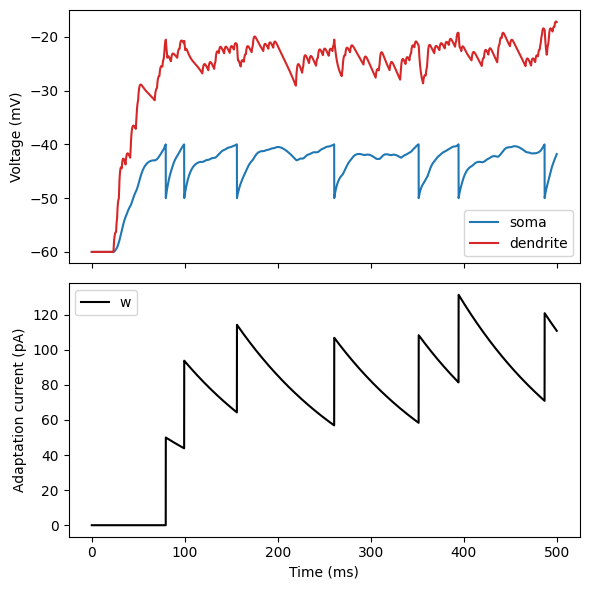

In [4]:
one_function_to_rule_them_all(soma, dend)

<div class="extra-info">
The upper panel shows how the somatic and dendritic voltages evolve over time in 
response to random synaptic input on the dendrite. The lower panel illustrates 
the adaptation current dynamics and how it is influenced by somatic spiking. Next,
we’ll try to reproduce the same model behavior using custom equations.
</div>

## Customizing a Soma

<div class="extra-info">
Let's first inspect the somatic equations that were generated by Dendrify:
</div>

In [5]:
print(soma.equations)

dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma - w_soma) / C_soma  :volt
dw_soma/dt = (a_soma * (V_soma-EL_soma) - w_soma) / tauw_soma  :amp
I_soma = I_ext_soma  :amp
I_ext_soma  :amp


<div class="extra-info">
Now let's try to create the same equations starting from a simple passive soma:
</div>

In [6]:
soma_custom1 = Soma('soma', cm_abs=200*pF, gl_abs=10*nS)
print(soma_custom1.equations)

dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma) / C_soma  :volt
I_soma = I_ext_soma  :amp
I_ext_soma  :amp


### Option 1: Replacing existing equations

In [7]:
custom_eqs = '''
dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma - w_soma) / C_soma  :volt
dw_soma/dt = (a_soma * (V_soma-EL_soma) - w_soma) / tauw_soma  :amp'''

soma_custom1.replace_equations(
    'dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma) / C_soma  :volt',
    custom_eqs)

print(soma_custom1.equations)


dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma - w_soma) / C_soma  :volt
dw_soma/dt = (a_soma * (V_soma-EL_soma) - w_soma) / tauw_soma  :amp
I_soma = I_ext_soma  :amp
I_ext_soma  :amp


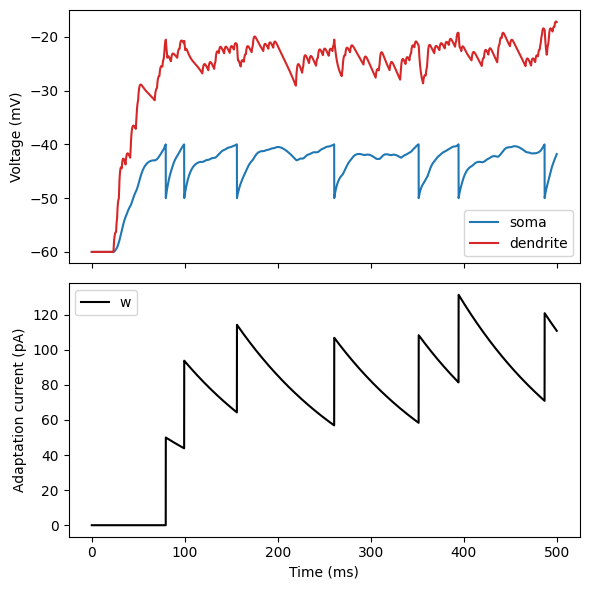

In [8]:
one_function_to_rule_them_all(soma_custom1, dend)

<div class="extra-info">
Notice how both the equations and the model response are identical to the control model.
</div>

### Option 2: targeted string replacements and additions

In [9]:
soma_custom2 = Soma('soma', cm_abs=200*pF, gl_abs=10*nS)
soma_custom2.replace_equations(
    "I_soma)",
    "I_soma - w_soma)")

soma_custom2.add_equations(
    'dw_soma/dt = (a_soma * (V_soma-EL_soma) - w_soma) / tauw_soma  :amp')

print(soma_custom2.equations)

dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma - w_soma) / C_soma  :volt
I_soma = I_ext_soma  :amp
I_ext_soma  :amp
dw_soma/dt = (a_soma * (V_soma-EL_soma) - w_soma) / tauw_soma  :amp


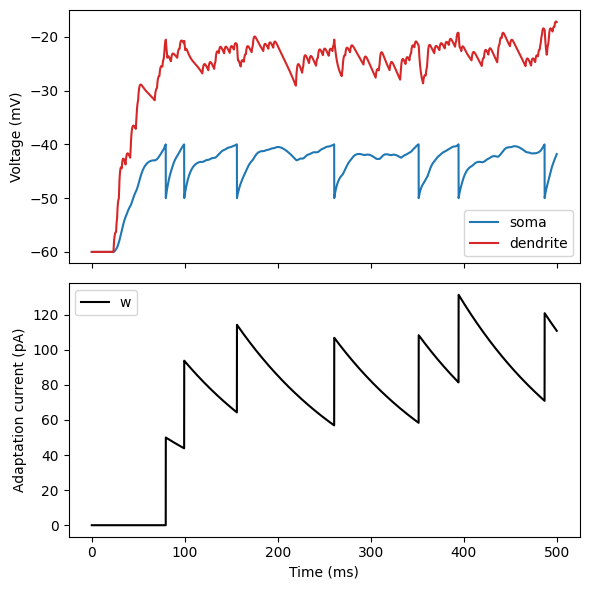

In [10]:
one_function_to_rule_them_all(soma_custom2, dend)

<div class="extra-info">
Once again, we’ve replicated the control model using more targeted string formatting.
</div>

## Customizing a Dendrite

<div class="extra-info">
Let’s first take a look at the dendritic equations generated by Dendrify. Notice that this time, the equations are more complex, as they describe the AMPA and NMDA synaptic dynamics.
</div>


In [11]:
print(dend.equations)

dV_dend/dt = (gL_dend * (EL_dend-V_dend) + I_dend) / C_dend  :volt
I_dend = I_ext_dend + I_NMDA_x_dend + I_AMPA_x_dend  :amp
I_ext_dend  :amp
I_AMPA_x_dend = g_AMPA_x_dend * (E_AMPA-V_dend) * s_AMPA_x_dend * w_AMPA_x_dend  :amp
ds_AMPA_x_dend/dt = -s_AMPA_x_dend / t_AMPA_decay_x_dend  :1
I_NMDA_x_dend = g_NMDA_x_dend * (E_NMDA-V_dend) * s_NMDA_x_dend / (1 + Mg_con * exp(-Alpha_NMDA*(V_dend/mV+Gamma_NMDA)) / Beta_NMDA) * w_NMDA_x_dend  :amp
ds_NMDA_x_dend/dt = -s_NMDA_x_dend/t_NMDA_decay_x_dend  :1


<div class="extra-info">
Like in the previous example, we will start from a passive dendritic compartment
and then modify its equations using the `replace_equations` and `add_equations`
methods provided by Dendrify.
</div>

In [12]:
dend_custom = Dendrite('dend', cm_abs=50*pF, gl_abs=2.5*nS)
print(dend_custom.equations)

dV_dend/dt = (gL_dend * (EL_dend-V_dend) + I_dend) / C_dend  :volt
I_dend = I_ext_dend  :amp
I_ext_dend  :amp


In [13]:
dend_custom.replace_equations(
    'I_dend = I_ext_dend  :amp',
    'I_dend = I_ext_dend + I_NMDA_x_dend + I_AMPA_x_dend  :amp')

custom_synaptic_eqs = """
I_AMPA_x_dend = g_AMPA_x_dend * (E_AMPA-V_dend) * s_AMPA_x_dend * w_AMPA_x_dend  :amp
ds_AMPA_x_dend/dt = -s_AMPA_x_dend / t_AMPA_decay_x_dend  :1
I_NMDA_x_dend = g_NMDA_x_dend * (E_NMDA-V_dend) * s_NMDA_x_dend / (1 + Mg_con * exp(-Alpha_NMDA*(V_dend/mV+Gamma_NMDA)) / Beta_NMDA) * w_NMDA_x_dend  :amp
ds_NMDA_x_dend/dt = -s_NMDA_x_dend/t_NMDA_decay_x_dend  :1"""

dend_custom.add_equations(custom_synaptic_eqs)

print(dend_custom.equations)


dV_dend/dt = (gL_dend * (EL_dend-V_dend) + I_dend) / C_dend  :volt
I_dend = I_ext_dend + I_NMDA_x_dend + I_AMPA_x_dend  :amp
I_ext_dend  :amp

I_AMPA_x_dend = g_AMPA_x_dend * (E_AMPA-V_dend) * s_AMPA_x_dend * w_AMPA_x_dend  :amp
ds_AMPA_x_dend/dt = -s_AMPA_x_dend / t_AMPA_decay_x_dend  :1
I_NMDA_x_dend = g_NMDA_x_dend * (E_NMDA-V_dend) * s_NMDA_x_dend / (1 + Mg_con * exp(-Alpha_NMDA*(V_dend/mV+Gamma_NMDA)) / Beta_NMDA) * w_NMDA_x_dend  :amp
ds_NMDA_x_dend/dt = -s_NMDA_x_dend/t_NMDA_decay_x_dend  :1


<div class="extra-info">
SPOILER ALERT!

Although the custom dendrite has identical equations to the control dendrite, running the same simulation will result in an error. Scroll down to find out why.
</div>


In [14]:
one_function_to_rule_them_all(soma, dend_custom)

BrianObjectException: Error encountered with object named 'neurongroup_1'.
Object was created here (most recent call only, full details in debug log):
  File '/home/michalis/.conda/envs/brian/lib/python3.12/site-packages/dendrify/neuronmodel.py', line 362, in make_neurongroup
    group = NeuronGroup(N,

An error occurred when preparing an object. (See above for original error message and traceback.)

<div class="extra-info">
Although we matched the default dendrite equations, we didn’t provide values for some key parameters. This can be fixed using the `add_params` method. See below:
</div>

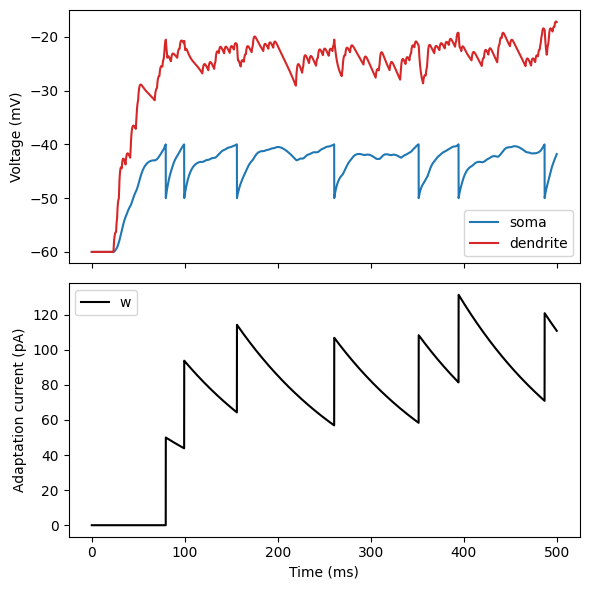

In [15]:
dend_custom_params = {
    't_AMPA_decay_x_dend': 2*ms,  # tau AMPA
    't_NMDA_decay_x_dend': 60*ms, # tau NMDA
    'g_AMPA_x_dend': 3*nS,        # AMPA conductance
    'g_NMDA_x_dend': 3*nS,        # NMDA conductance
    'w_NMDA_x_dend': 1,           # NMDA weight
    'w_AMPA_x_dend': 1,           # AMPA weight
    }
dend_custom.add_params(dend_custom_params)

one_function_to_rule_them_all(soma, dend_custom)

## Creating and simulating a custom model from scratch

<div class="alert alert-info">
Note

When creating a custom model from scratch, we have the flexibility to simplify
certain equations or variable names. This is because we know in advance the exact
model we want to build. In contrast, Dendrify is agnostic to the user’s needs and
must account for all possible model features to avoid breaking or causing simulation
errors. This is why you might encounter some ugly or long variable or parameter
names when using stock Dendrify.
</div>


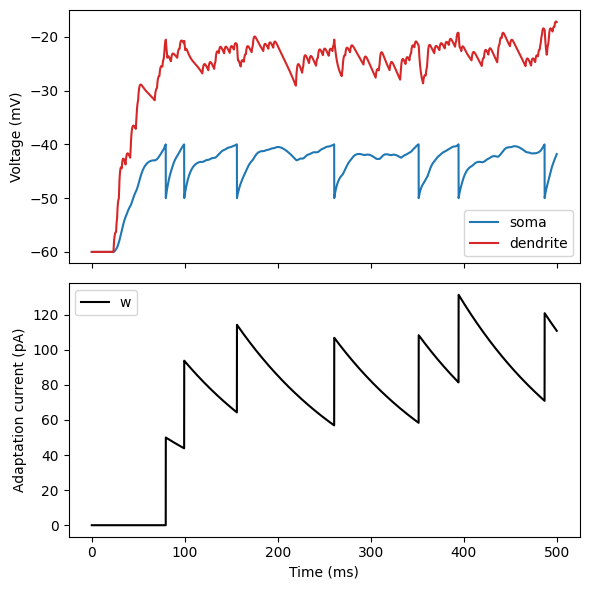

In [16]:
# Create and customize soma
soma = Soma('soma', cm_abs=200*pF, gl_abs=10*nS)
soma.replace_equations("I_soma)", "I_soma - w)")
soma.add_equations('dw/dt = (a * (V_soma-EL_soma) - w) / tauw  :amp')

# Create and customize dendrite
dend = Dendrite('dend', cm_abs=50*pF, gl_abs=2.5*nS)
dend.replace_equations(
    'I_dend = I_ext_dend  :amp',
    'I_dend = I_ext_dend + I_NMDA + I_AMPA  :amp')
custom_synaptic_eqs = """
I_AMPA = g_AMPA * (E_AMPA-V_dend) * s_AMPA  :amp
ds_AMPA/dt = -s_AMPA / t_AMPA_decay  :1
I_NMDA = g_NMDA * (E_NMDA-V_dend) * s_NMDA / (1 + Mg_con * exp(-Alpha_NMDA*(V_dend/mV+Gamma_NMDA)) / Beta_NMDA)  :amp
ds_NMDA/dt = -s_NMDA/t_NMDA_decay  :1"""
dend.add_equations(custom_synaptic_eqs)

# Create neuron model and add parameters
model = NeuronModel([(soma, dend, 15*nS)], v_rest=-60*mV)
model.add_params({
        # spiking parameters
        'Vth': -40*mV,
        'tauw': 150*ms,
        'a': 0*nS,
        'b': 50*pA,
        'Vr': -50*mV,
        # synaptic parameters
        't_AMPA_decay': 2*ms,
        't_NMDA_decay': 60*ms,
        'g_AMPA': 3*nS,
        'g_NMDA': 3*nS})

# Create neuron group
neuron = model.make_neurongroup(
        1, method='euler',
        threshold='V_soma > Vth',
        reset='V_soma = Vr; w += b',
        refractory=4*ms)

# Create necessary Brian objects
poisson = b.PoissonGroup(10, rates=20*Hz)
syn = b.Synapses(poisson, neuron, on_pre='s_AMPA += 1; s_NMDA += 1')
syn.connect(p=1)
mon = b.StateMonitor(neuron, ['V_soma', 'V_dend', 'w'], record=True)
net = b.Network(neuron, poisson, syn, mon)

# Run simulation
b.start_scope()
b.seed(42)
net.run(500*ms)

# Plot results
time = mon.t / ms
v_soma = mon.V_soma[0] / mV
v_dend = mon.V_dend[0] / mV
w = mon.w[0] / pA

fig, (ax1, ax2) = b.subplots(2, 1, figsize=[6, 6], sharex=True)
ax1.plot(time, v_soma, label='soma')
ax1.plot(time, v_dend, label='dendrite', c='C3')
ax1.set_ylabel('Voltage (mV)')
ax1.legend()
ax2.plot(time, w, color='black', label='w')
ax2.set_ylabel('Adaptation current (pA)')
ax2.set_xlabel('Time (ms)')
ax2.legend()
fig.tight_layout()
b.show()

## Customizing a NeuronModel

<div class="extra-info">
Note that all the customization options available for `Soma` and `Dendrite` objects are also available for the final `NeuronModel`. The methods `add_equations`, `replace_equations`, and `add_params` are shared among these three classes.
</div>

In [17]:
print(model.equations)

dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma - w) / C_soma  :volt
I_soma = I_ext_soma + I_dend_soma   :amp
I_ext_soma  :amp
dw/dt = (a * (V_soma-EL_soma) - w) / tauw  :amp
I_dend_soma = (V_dend-V_soma) * g_dend_soma  :amp

dV_dend/dt = (gL_dend * (EL_dend-V_dend) + I_dend) / C_dend  :volt
I_dend = I_ext_dend + I_soma_dend  + I_NMDA + I_AMPA  :amp
I_ext_dend  :amp

I_AMPA = g_AMPA * (E_AMPA-V_dend) * s_AMPA  :amp
ds_AMPA/dt = -s_AMPA / t_AMPA_decay  :1
I_NMDA = g_NMDA * (E_NMDA-V_dend) * s_NMDA / (1 + Mg_con * exp(-Alpha_NMDA*(V_dend/mV+Gamma_NMDA)) / Beta_NMDA)  :amp
ds_NMDA/dt = -s_NMDA/t_NMDA_decay  :1
I_soma_dend = (V_soma-V_dend) * g_soma_dend  :amp


In [18]:
model.replace_equations(
    'I_soma_dend = (V_soma-V_dend) * g_soma_dend  :amp',
    '\n\nHello World!'
)
model.add_equations('Have a beautiful and productive day!')
print(model.equations)

dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma - w) / C_soma  :volt
I_soma = I_ext_soma + I_dend_soma   :amp
I_ext_soma  :amp
dw/dt = (a * (V_soma-EL_soma) - w) / tauw  :amp
I_dend_soma = (V_dend-V_soma) * g_dend_soma  :amp

dV_dend/dt = (gL_dend * (EL_dend-V_dend) + I_dend) / C_dend  :volt
I_dend = I_ext_dend + I_soma_dend  + I_NMDA + I_AMPA  :amp
I_ext_dend  :amp

I_AMPA = g_AMPA * (E_AMPA-V_dend) * s_AMPA  :amp
ds_AMPA/dt = -s_AMPA / t_AMPA_decay  :1
I_NMDA = g_NMDA * (E_NMDA-V_dend) * s_NMDA / (1 + Mg_con * exp(-Alpha_NMDA*(V_dend/mV+Gamma_NMDA)) / Beta_NMDA)  :amp
ds_NMDA/dt = -s_NMDA/t_NMDA_decay  :1


Hello World!

Have a beautiful and productive day!
